### *Bandits Trade Stocks*

This notebook implements a simple implementation of the k-arm bandit probelm. Cummulative rewards are added daily and simulate holding a stock for 1 day. The performance of this strategy has been compared with 100 random implementations of the strategy.

The results obtained for the period start_date = '2015-01-01', end_date = '2024-12-31 are statistically significant at a $\alpha=0.005$ significance level compared to the alternative hypothesis (picking the stocks at random).

### *Future directions*

It can be shown that, in this example, the model just learnt to bet on NVDA most of the time. However, this is a desirble outcome since the model was not allowed to look into the future. An ideal and more robust result would be for the bandit to perform better than the most traded stock.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use('dark_background')

# Export data

import yfinance as yf

# Replicability

np.random.seed(42)

In [3]:
# Stock Selection and Dates

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'WMT']

start_date = '2015-01-01'
end_date = '2024-12-31'

In [4]:
# Data extraction

data = yf.download(stocks, start=start_date, end=end_date)['Close']
data = data.dropna()
# Calculate daily returns
returns = data.pct_change().shift(-1)[:-1]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [5]:
# ε-greedy bandit algorithm
class EpsilonGreedyBandit:
    def __init__(self, n_arms, epsilon):
        self.n = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm has been pulled
        self.values = np.zeros(n_arms)  # Estimated value for each arm

    def select_arm(self):
        if np.random.rand() > self.epsilon:
            # Exploition: Select max arg
            return np.argmax(self.values)
        else:
            # Exploration: random selection
            return np.random.randint(0, self.n)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # Update the estimated value
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [7]:
# ε-greedy bandit algorithm
class GammaEpsilonGreedyBandit:
    def __init__(self, n_arms, epsilon, gamma = 0.98):
        self.n = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm has been pulled
        self.values = np.zeros(n_arms)  # Estimated value for each arm
        self.gamma = gamma # Discount rate to update rewards

    def select_arm(self):
        if np.random.rand() > self.epsilon:
            # Exploition: Select max arg
            return np.argmax(self.values)
        else:
            # Exploration: random selection
            return np.random.randint(0, self.n)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        value = self.values[chosen_arm]
        # Update the estimated value
        new_value = self.gamma * value + (1-self.gamma) * reward
        self.values[chosen_arm] = new_value

In [8]:
# Initial Parameters
epsilon = 0.1
n_arms = len(stocks)
bandit = EpsilonGreedyBandit(n_arms, epsilon)
gamma_bandit = GammaEpsilonGreedyBandit(n_arms, epsilon, gamma=0.99)

# Bandit simulation data
num_days = len(returns)

cumulative_rewards_bandit = []
total_reward_bandit = 0
daily_rewards_bandit = []
chosen_arms_bandit = []

cumulative_rewards_bandit_gamma = []
total_reward_bandit_gamma = 0
daily_rewards_bandit_gamma = []
chosen_arms_bandit_gamma = []

In [9]:
# Simulation

for t in range(num_days):
    # Select an arm
    arm = bandit.select_arm()
    chosen_arms_bandit.append(arm)

    gamma_arm = gamma_bandit.select_arm()
    chosen_arms_bandit_gamma.append(gamma_arm)
    
    # Get the reward
    reward = returns.iloc[t, arm]  # Return on day t for give stock
    reward = np.nan_to_num(reward)  # Handle NaN

    reward_gamma = returns.iloc[t, gamma_arm]
    reward_gamma = np.nan_to_num(reward_gamma)
    
    # Update the bandit with observed reward
    bandit.update(arm, reward)
    gamma_bandit.update(gamma_arm, reward_gamma)
    
    # Update total and cumulative rewards
    total_reward_bandit += reward
    daily_rewards_bandit.append(reward)
    cumulative_rewards_bandit.append(total_reward_bandit)

    total_reward_bandit_gamma += reward_gamma
    daily_rewards_bandit_gamma.append(reward_gamma)
    cumulative_rewards_bandit_gamma.append(total_reward_bandit_gamma)

In [10]:
# Simulate 100 random strategies
num_strategies = 100
cumulative_rewards_random = np.zeros((num_strategies, num_days))

for s in range(num_strategies):
    total_reward_random = 0
    cumulative_reward = []
    for t in range(num_days):
        arm = np.random.randint(0, n_arms)
        reward = returns.iloc[t, arm]
        reward = np.nan_to_num(reward)
        total_reward_random += reward
        cumulative_reward.append(total_reward_random)
    cumulative_rewards_random[s] = cumulative_reward

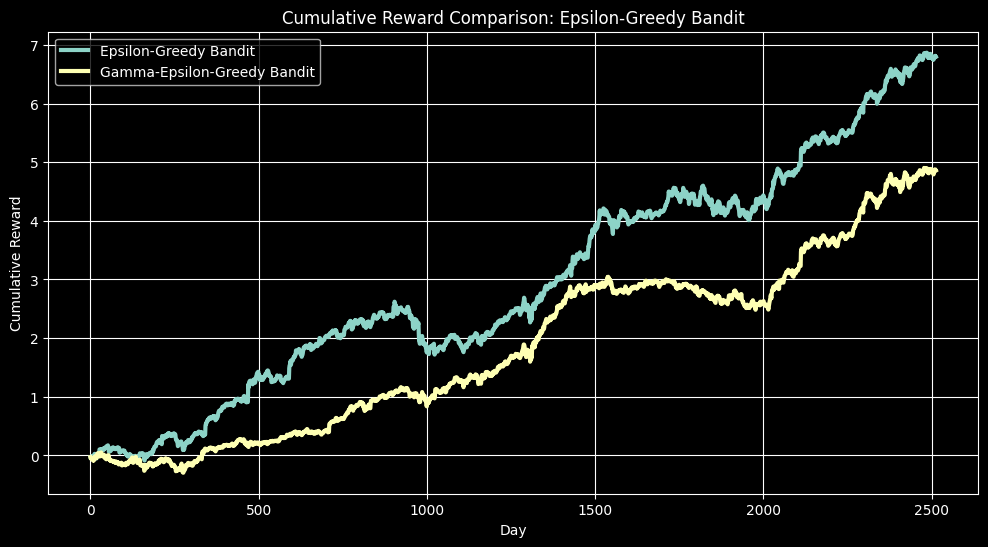

In [11]:
# Plot bandit cumulative rewards 
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards_bandit, label='Epsilon-Greedy Bandit', linewidth=3)
plt.plot(cumulative_rewards_bandit_gamma, label='Gamma-Epsilon-Greedy Bandit', linewidth=3)


plt.xlabel('Day')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison: Epsilon-Greedy Bandit')
plt.legend()
plt.grid(True)
plt.show()

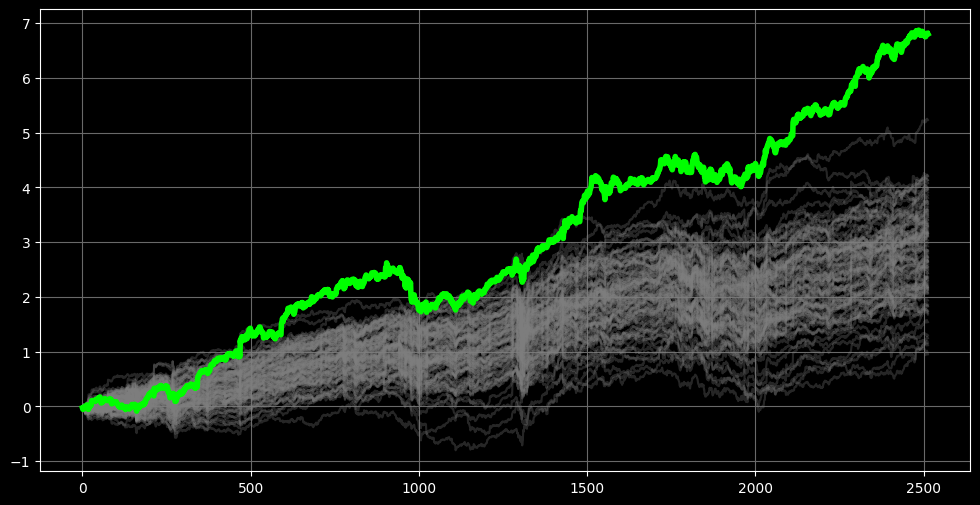

In [19]:
# Plot bandit cumulative rewards 
plt.figure(figsize=(12, 6))


# Plot random strategy cumulative rewards
for s in range(num_strategies):
    plt.plot(cumulative_rewards_random[s], color='grey', alpha=0.3)

plt.plot(cumulative_rewards_bandit, label='Epsilon-Greedy Bandit', linewidth=4, color="lime")

# Calculate and plot average of random strategies
average_random = np.mean(cumulative_rewards_random, axis=0)
#plt.plot(average_random, label='Average Random Strategy', color='red', linestyle='--', linewidth=2)

#plt.xlabel('Day')
#plt.ylabel('Cumulative Reward')
#plt.title('Cumulative Reward Comparison: Epsilon-Greedy Bandit vs 100 Random Strategies')
#plt.legend()
plt.grid(True, color = 'dimgrey')
plt.show()

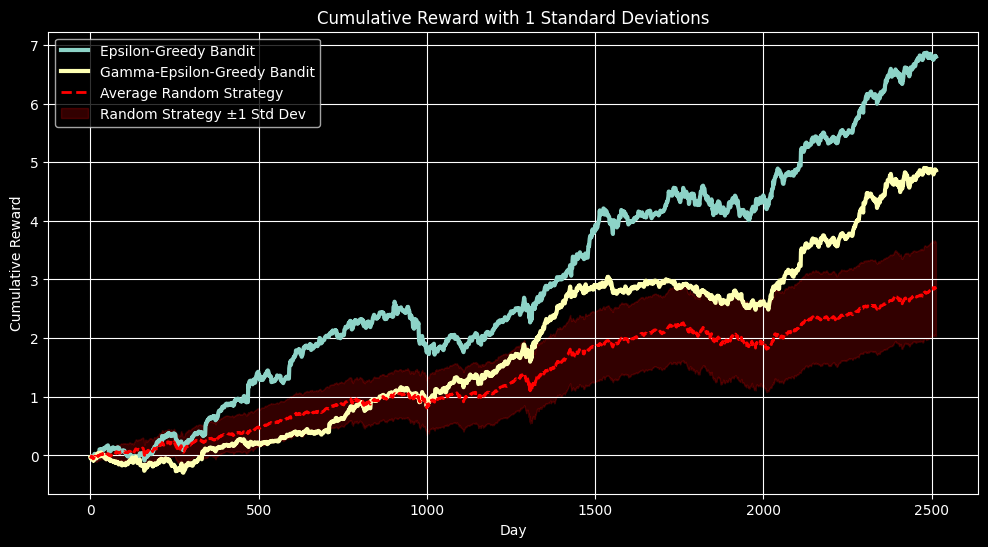

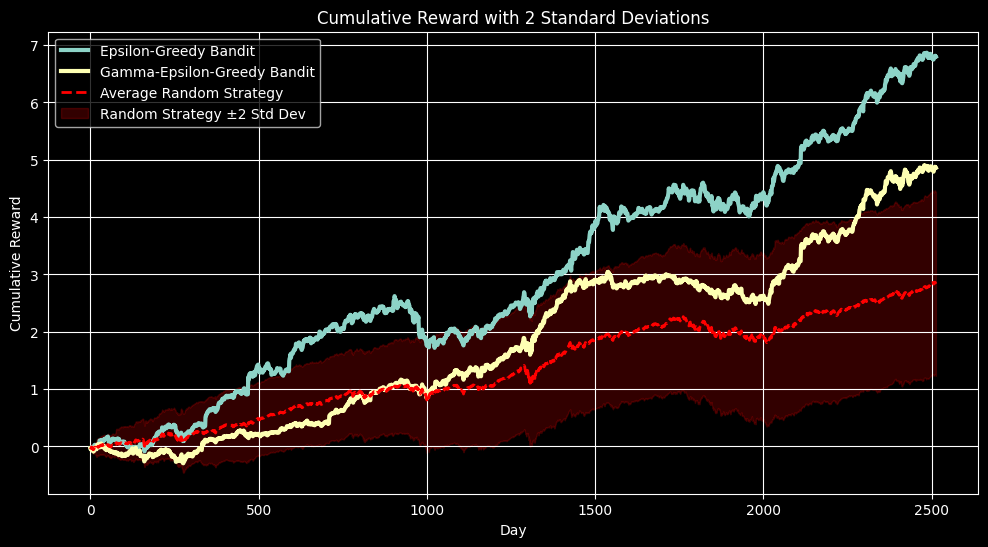

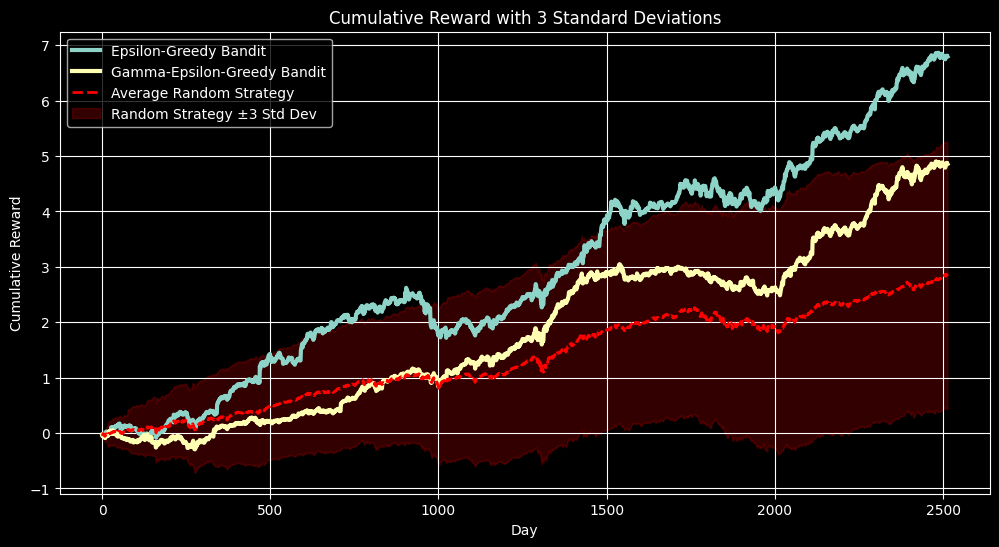

In [11]:
average_random = np.mean(cumulative_rewards_random, axis=0)
std_random = np.std(cumulative_rewards_random, axis=0)

num_std_random = [1,2,3]

for num in num_std_random:
    # Plot cumulative rewards
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_rewards_bandit, label='Epsilon-Greedy Bandit', linewidth=3)
    plt.plot(cumulative_rewards_bandit_gamma, label='Gamma-Epsilon-Greedy Bandit', linewidth=3)

    # Plot average cumulative rewards of random
    plt.plot(average_random, label='Average Random Strategy', color='red', linestyle='--', linewidth=2)

    # Plot "num" standard deviation bands around avg
    plt.fill_between(range(num_days),
                     average_random - num * std_random,
                     average_random + num * std_random,
                     color='red', alpha=0.2, label=f'Random Strategy ±{num} Std Dev')

    plt.xlabel('Day')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Reward with {num} Standard Deviations')
    plt.legend()
    plt.grid(True)
    plt.show()

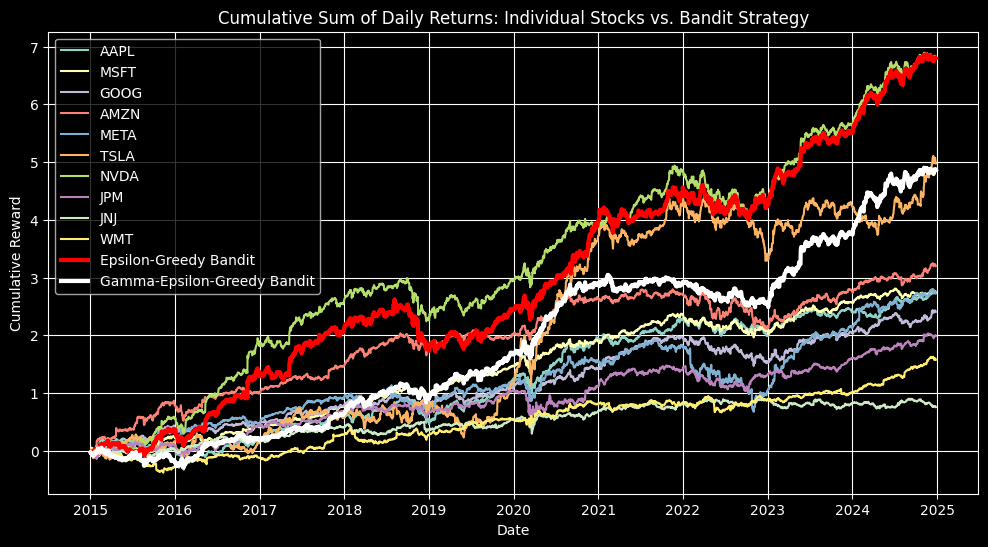

In [12]:
# Comparison with stock returns

# Calculate cumulative sum of daily returns for each stock
cumulative_rewards_stocks = returns.cumsum()

plt.figure(figsize=(12, 6))
for stock in stocks:
    plt.plot(cumulative_rewards_stocks.index, cumulative_rewards_stocks[stock], label=stock)

# Plot the cumulative rewards of the ε-greedy bandit
plt.plot(cumulative_rewards_stocks.index, cumulative_rewards_bandit, label='Epsilon-Greedy Bandit', linewidth=3, color='red')
plt.plot(cumulative_rewards_stocks.index, cumulative_rewards_bandit_gamma, label='Gamma-Epsilon-Greedy Bandit', linewidth=3, color='white')
plt.xlabel('Date')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Sum of Daily Returns: Individual Stocks vs. Bandit Strategy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Simulate 100 random strategies
num_strategies = 1000
cumulative_rewards_random = np.zeros((num_strategies, num_days))

for s in range(num_strategies):
    total_reward_random = 0
    cumulative_reward = []
    for t in range(num_days):
        arm = np.random.randint(0, n_arms)
        reward = returns.iloc[t, arm]
        reward = np.nan_to_num(reward)
        total_reward_random += reward
        cumulative_reward.append(total_reward_random)
    cumulative_rewards_random[s] = cumulative_reward

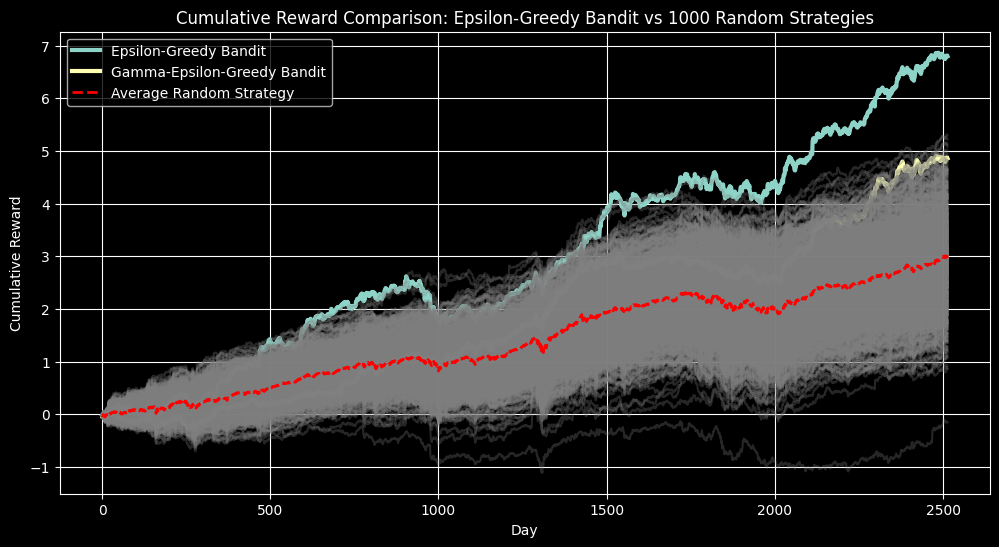

In [17]:
# Plot bandit cumulative rewards 
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards_bandit, label='Epsilon-Greedy Bandit', linewidth=3)
plt.plot(cumulative_rewards_bandit_gamma, label='Gamma-Epsilon-Greedy Bandit', linewidth=3)

# Plot random strategy cumulative rewards
for s in range(num_strategies):
    plt.plot(cumulative_rewards_random[s], color='grey', alpha=0.3)

# Calculate and plot average of random strategies
average_random = np.mean(cumulative_rewards_random, axis=0)
plt.plot(average_random, label='Average Random Strategy', color='red', linestyle='--', linewidth=2)

plt.xlabel('Day')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison: Epsilon-Greedy Bandit vs 1000 Random Strategies')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Simulate 100 random strategies
num_strategies = 10000
cumulative_rewards_random = np.zeros((num_strategies, num_days))

for s in range(num_strategies):
    total_reward_random = 0
    cumulative_reward = []
    for t in range(num_days):
        arm = np.random.randint(0, n_arms)
        reward = returns.iloc[t, arm]
        reward = np.nan_to_num(reward)
        total_reward_random += reward
        cumulative_reward.append(total_reward_random)
    cumulative_rewards_random[s] = cumulative_reward

/Users/manu13/anaconda3/envs/my-manim-environment/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


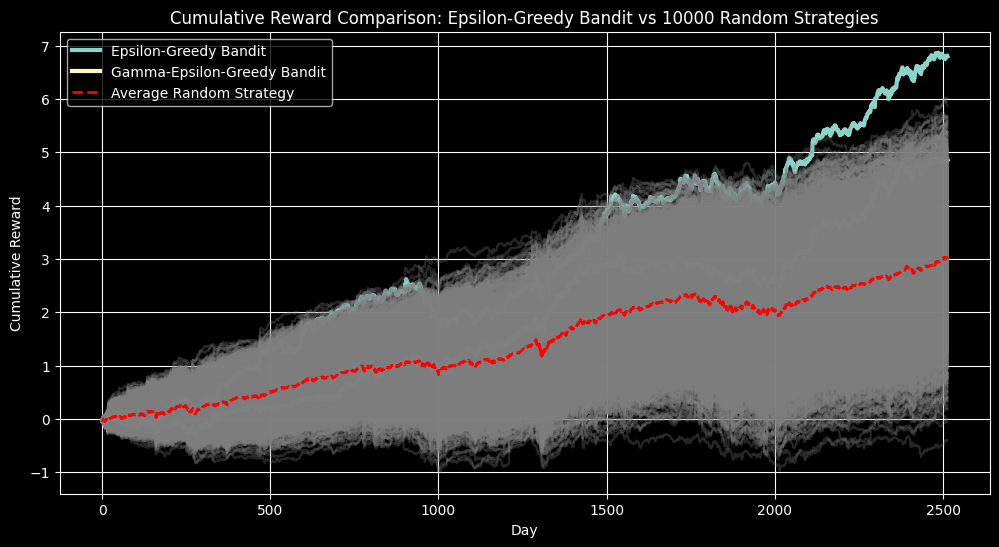

In [19]:
# Plot bandit cumulative rewards 
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards_bandit, label='Epsilon-Greedy Bandit', linewidth=3)
plt.plot(cumulative_rewards_bandit_gamma, label='Gamma-Epsilon-Greedy Bandit', linewidth=3)

# Plot random strategy cumulative rewards
for s in range(num_strategies):
    plt.plot(cumulative_rewards_random[s], color='grey', alpha=0.3)

# Calculate and plot average of random strategies
average_random = np.mean(cumulative_rewards_random, axis=0)
plt.plot(average_random, label='Average Random Strategy', color='red', linestyle='--', linewidth=2)

plt.xlabel('Day')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison: Epsilon-Greedy Bandit vs 10000 Random Strategies')
plt.legend()
plt.grid(True)
plt.show()